In [1]:
# load jpeg image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import openpyxl
from openpyxl.styles import PatternFill

img_path = Path('koty_a_dyne.jpg')

img = cv2.imread(img_path)

In [2]:
img.shape

(664, 612, 3)

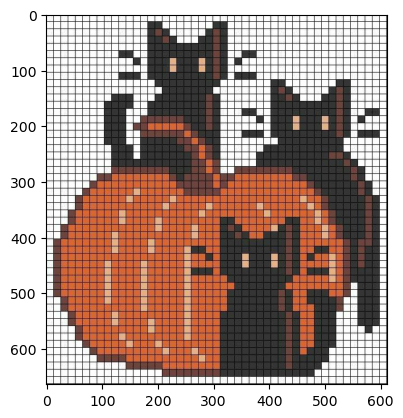

In [3]:
b,g,r = cv2.split(img)
frame_rgb = cv2.merge((r,g,b))
plt.imshow(frame_rgb)
plt.show()

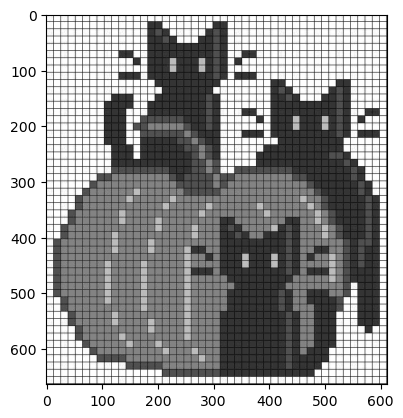

In [4]:
# convert to grayscale
gs_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gs_img, cmap='gray')
plt.show()

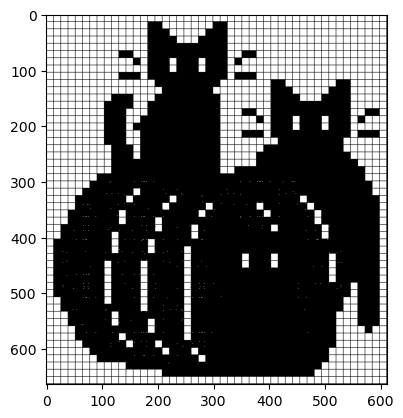

In [5]:
# convert to black and white to find grid lines
(thresh, bw_img) = cv2.threshold(gs_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(bw_img, cmap='gray')
plt.show()

In [6]:
# helper variable to tell at which row to look for grid marks
first_row_center_offset = 7

In [7]:
col_count = np.where(bw_img[first_row_center_offset, :] == 0)[0].shape[0] - 1
row_count = np.where(bw_img[:, first_row_center_offset] == 0)[0].shape[0] - 1
grid_size = img.shape[1] // col_count
col_count, row_count, grid_size

(47, 51, 13)

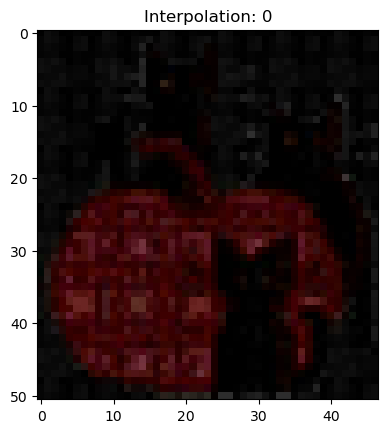

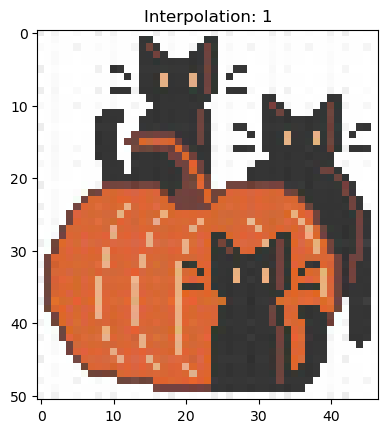

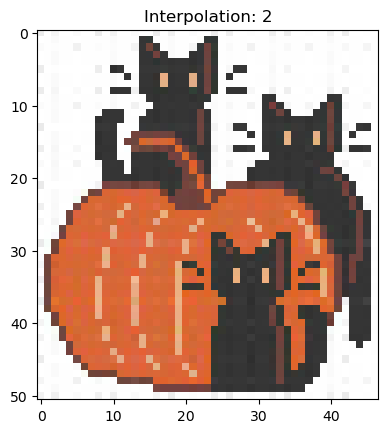

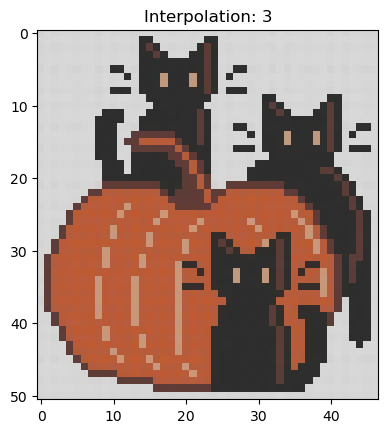

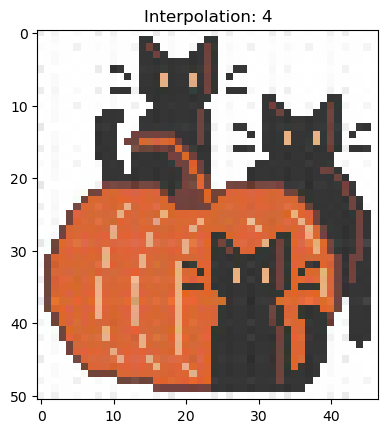

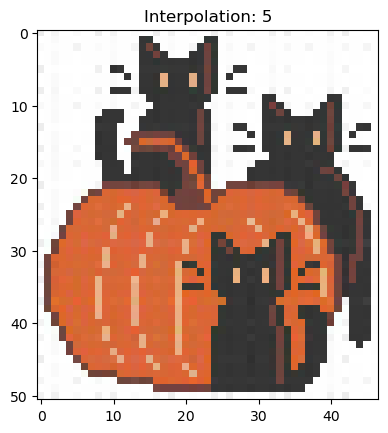

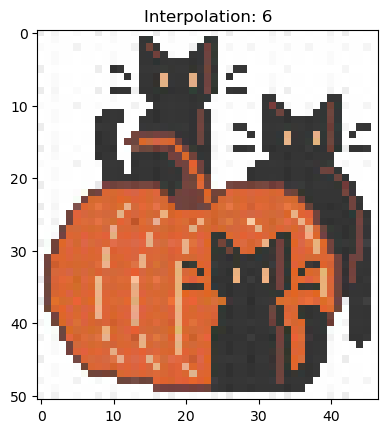

In [8]:
# try different interpolation methods
for inter in range(0,7):
    downsampled_img = cv2.resize(img, (col_count, row_count), interpolation=inter)
    b,g,r = cv2.split(downsampled_img)
    frame_rgb = cv2.merge((r,g,b))
    plt.imshow(frame_rgb)
    plt.title(f'Interpolation: {inter}')
    plt.show()

In [9]:
# create resize function that uses the center of each grid cell to sample the color, instead of interpolation
def resize_using_grid_cell_center(img, grid_size, col_count, row_count):
    resized_img = np.zeros((row_count, col_count, 3), dtype=np.uint8)
    grid_center_offset = grid_size // 2
    for row in range(row_count):
        for col in range(col_count):
            y = row * grid_size + grid_center_offset
            x = col * grid_size + grid_center_offset
            resized_img[row, col] = img[y, x]
    return resized_img

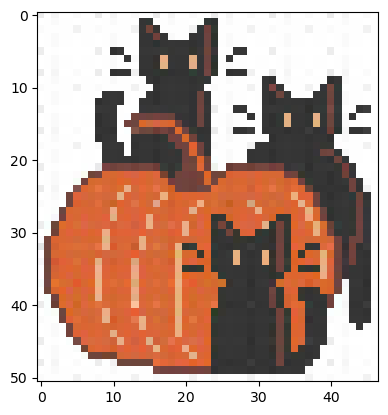

In [10]:
img_resized = resize_using_grid_cell_center(img, grid_size, col_count, row_count)
b,g,r = cv2.split(img_resized)
frame_rgb = cv2.merge((r,g,b))
plt.imshow(frame_rgb)
plt.show()

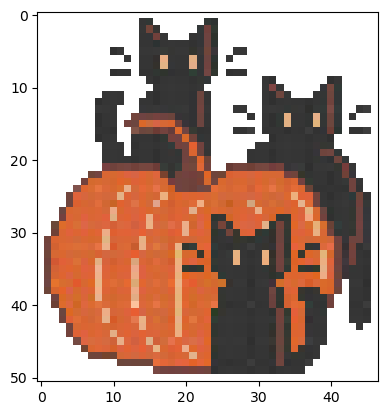

In [11]:
# denoise image background by setting pixels close to white to pure white
tolerance = 60
mask = np.all(img_resized >= (255 - tolerance), axis=-1)
img_resized[mask] = [255, 255, 255]
b,g,r = cv2.split(img_resized)
frame_rgb = cv2.merge((r,g,b))
plt.imshow(frame_rgb)
plt.show()

In [ ]:
# export to excel file with square cells colored according to the resized image
wb = openpyxl.Workbook()
ws = wb.active
for row in range(img_resized.shape[0]):
    for col in range(img_resized.shape[1]):
        b, g, r = img_resized[row, col]
        fill = PatternFill(start_color=f'{r:02x}{g:02x}{b:02x}', end_color=f'{r:02x}{g:02x}{b:02x}', fill_type='solid')
        ws.cell(row=row + 1, column=col + 1).fill = fill

# set width and height of cells to make them square
for col in range(1, img_resized.shape[1] + 1):
    ws.column_dimensions[openpyxl.utils.get_column_letter(col)].width = (19/21) * 3
for row in range(1, img_resized.shape[0] + 1):
    ws.row_dimensions[row].height = 14.25

wb.save(img_path.stem + '.xlsx')